<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross validation strategies

In this exercise will compare different CV strategies and we'll see:
* how using the best performing model out of a CV strategy is not a good idea
* how extimation of the generalization error changes with increasing k
* how estimations differ for different CV strategies
* how estimations are different from the empirical out of sample error tested on a large portion of data.

In particular, we'll study these effect dividing an original dataset $\mathcal{D}$ in two equal parts: an **estimation set**, $\mathcal{D}_1$ and a **validation set** $\mathcal{D}_2$.

To assess the effect of different CV strategies, we will further divide $\mathcal{D}_1$ into subfolds, retrieve the CV and then compare the results with the out of sample error on $\mathcal{D}_2$.  

<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/nested_CV.png" width="500"/>

In [1]:
%%capture
!pip install wget
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

loss = mean_absolute_error

df = pd.DataFrame(pd.read_pickle("https://github.com/nepslor/teaching/raw/main/TimeSeriesForecasting/data/tsc_example.pk"))
#data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));
#df = data[['all']].resample('1h', origin='start').mean()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

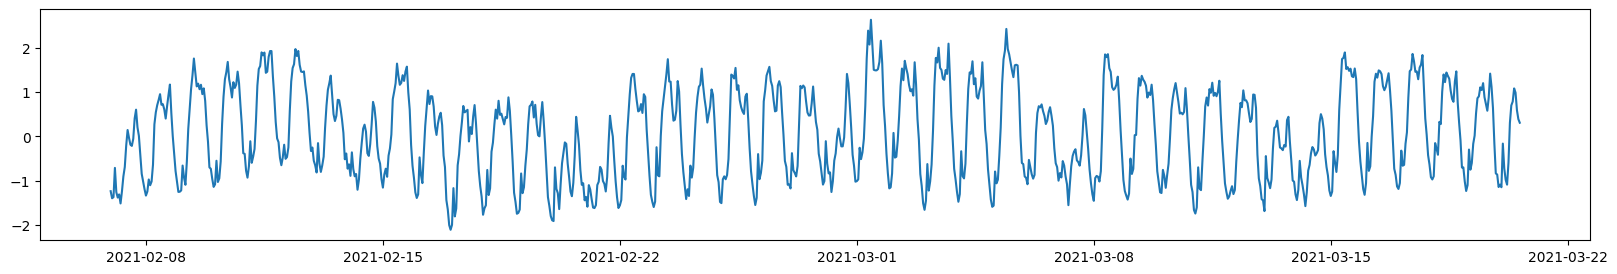

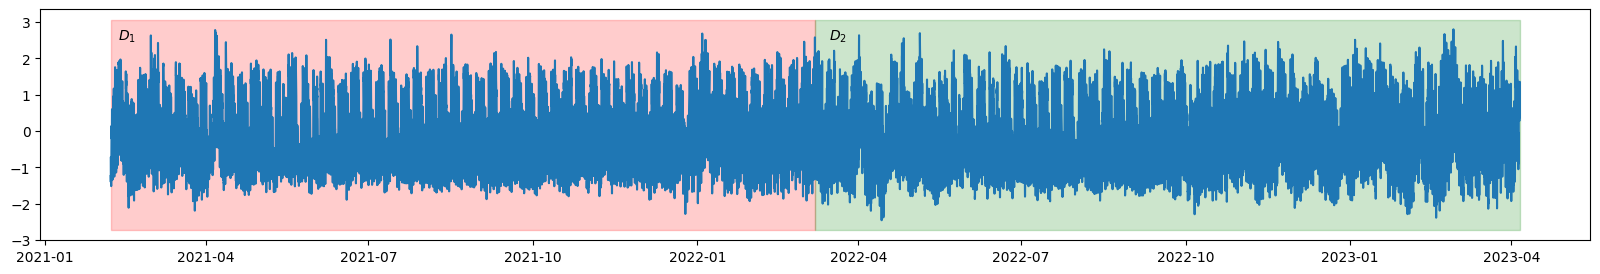

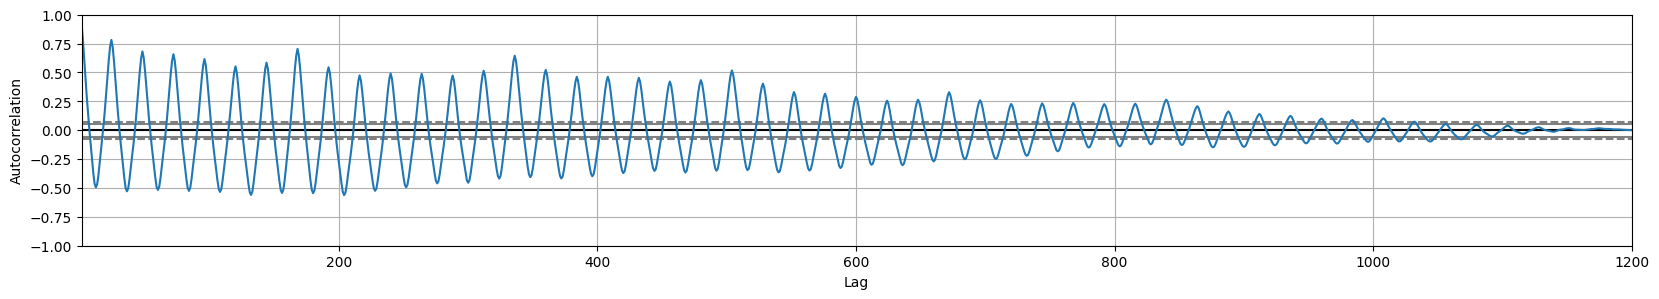

In [2]:
lagged_mav = lambda x, k: x.copy().rolling(k).mean()
lagged_mstd = lambda x, k: x.copy().rolling(k).std()
causal_norm = lambda x, k: ((x - lagged_mav(x, k))/lagged_mstd(x, k))
df = causal_norm(df, 24*30).iloc[24*30:]

# TS plot
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.plot(df.iloc[:1000, :])

# TS plot - datasets
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.plot(df)
ylims = ax.get_ylim()
ax.fill_betweenx(ylims, df.index[0], df.index[int(len(df)/2)], color='red', alpha=0.2)
ax.fill_betweenx(ylims, df.index[int(len(df)/2)], df.index[-1], color='green', alpha=0.2)
ax.text(df.index[100], 2.5, '$D_1$')
ax.text(df.index[int(len(df)*0.51)], 2.5, '$D_2$')

# ACF plot
plt.figure(figsize=(20, 3))
pd.plotting.autocorrelation_plot(df.iloc[:24*50])

Split the dataset in estimation and validation sets

In [3]:
df_1, df_2 = df.iloc[:int(len(df)/2)], df.iloc[int(len(df)/2):]

## CV strategies
The following code generates folds for:
* blocked CV strategy: it's the standard k-folds CV but without random shuffling
* TS-CV
* blocked CV with a purging window
* TS-CV with a purging window

In [4]:
def get_cv_idxs(df, n_splits=5, method='ts', purging=0):
  n_w = np.floor(len(df) / n_splits).astype(int)
  n_w_ts = np.floor(len(df) / (n_splits + 1)).astype(int)
  window = np.arange(n_w)
  window_purged = np.arange(-purging, n_w + purging)
  window_ts = np.arange(n_w_ts)
  tr_idx, te_idx = None, None
  for i in np.arange(n_splits):
    if method == 'cv':
      # retrieve test and train indexes for the CV case, also considering a
      # purging period
      # te_idx = ??
      # tr_idx = ??
    elif method == 'ts-cv':
      tr_idx = np.arange(n_w_ts * (i + 1) - int(purging/2))
      te_idx = np.setdiff1d(window_ts + n_w_ts * (i + 1), np.arange(purging/2) + n_w_ts * (i + 1))
    yield tr_idx, te_idx

Text(0.5, 1.0, 'purged ts-CV, k=10')

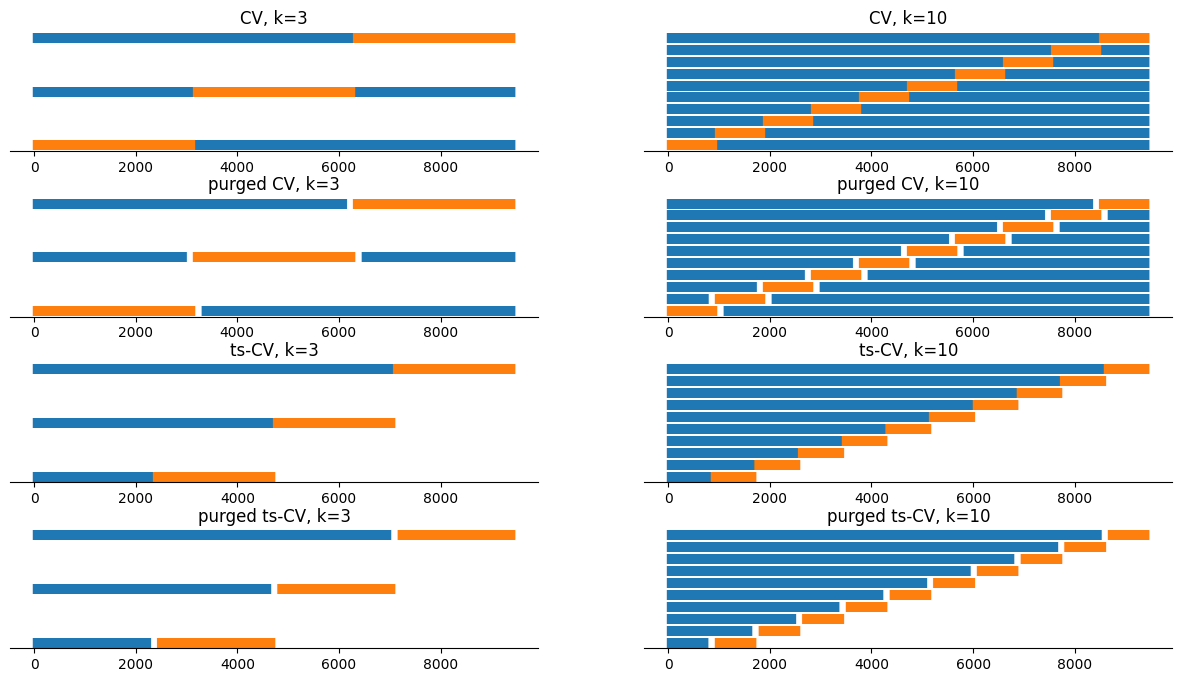

In [5]:
def plot_splits(splits, nsplits, ax=None):
  c = plt.get_cmap('tab10').colors
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))
  ax.cla()
  for s in range(nsplits):
    tr_idx, te_idx = next(splits)
    ax.scatter(tr_idx, tr_idx * 0 + s, marker='|', s=50, alpha=0.5, color=c[0])
    ax.scatter(te_idx, te_idx * 0 + s, marker='|', s=50, alpha=0.5, color=c[1])
    # remove spine
    ax.spines[['top', 'left','right']].set_visible(False)
    ax.set_yticks([])

# show different splits
fig, ax = plt.subplots(4, 2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

n_splits = 3
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv'), n_splits, ax=ax[0, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv', purging=24*7), n_splits, ax=ax[1, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv'), n_splits, ax=ax[2, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv', purging=24*7), n_splits, ax=ax[3, 0])
ax[0, 0].set_title('CV, k={}'.format(n_splits))
ax[1, 0].set_title('purged CV, k={}'.format(n_splits))
ax[2, 0].set_title('ts-CV, k={}'.format(n_splits))
ax[3, 0].set_title('purged ts-CV, k={}'.format(n_splits))

n_splits = 10
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv'), n_splits, ax=ax[0, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv', purging=24*7), n_splits, ax=ax[1, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv'), n_splits, ax=ax[2, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv', purging=24*7), n_splits, ax=ax[3, 1])

ax[0, 1].set_title('CV, k={}'.format(n_splits))
ax[1, 1].set_title('purged CV, k={}'.format(n_splits))
ax[2, 1].set_title('ts-CV, k={}'.format(n_splits))
ax[3, 1].set_title('purged ts-CV, k={}'.format(n_splits))



## Create the two datasets
In the following we perform an embedding using 8 days, 7 days are used as features to forecast the 8th day

In [6]:
def get_hankel(df, embedding=3):
  dfs = {}
  for c in df.columns:
    df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
    df_i.columns = [i for i in range(df_i.shape[1])]
    dfs[c] = df_i
  return pd.concat(dfs, axis=1)

def create_dataset(df, total_days=7):
  df_emb = get_hankel(df, embedding=total_days*24)
  x = df_emb.loc[:, df_emb.columns.get_level_values(1)<(total_days-1)*24]
  y = df_emb.loc[:, df_emb.columns.get_level_values(1)>=(total_days-1)*24]
  return x, y

total_days = 8
x_1, y_1 = create_dataset(df_1, total_days=total_days)
x_2, y_2 = create_dataset(df_2, total_days=total_days)


# Biased selection
What happen if we take the best performing model out of the CV selection process? We test this procedure using a standard blocked kCV.
1. We retrieve the k errors on the first dataset in CV. At the same time, for each one of the k models, we retrieve the error on the second dataset
2. We select the best model out of the kCV process and compare its error on the second dataset with the others.

## ❓What you think did happen?

In [7]:
n_splits = 30
splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv')
loss_1_i, loss_2_i = [], []
for i in range(n_splits):
  tr_idx, te_idx = next(splitter_cv)
  # fit-predict on fold
  # loss_1_i.append(??)
  # loss_2_i.append(??)

best_model = np.argmin(loss_1_i)
print('best model: {}'.format(best_model))

best model: 21


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].scatter(np.arange(len(loss_1_i)), np.sort(loss_1_i), c=np.array(loss_2_i)[np.argsort(loss_1_i)], cmap='plasma')
ax[1].plot(np.sort(loss_2_i))
ax[1].scatter(np.where(np.argsort(loss_2_i)==best_model), loss_2_i[best_model], color='r', label='best model on set 1')
ax[1].legend()
ax[0].set_title('set 1 losses, colored by set 2 losses')
ax[1].set_title('set 2 losses');

The following cell computes the CV score for all the 4 methods, using k=3.


In [9]:

n_splits = 3
splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv')
splitter_purged_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv', purging=24*total_days)
splitter_ts = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv')
splitter_purged_ts = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv', purging=24*total_days)

splitters = [splitter_cv, splitter_purged_cv, splitter_ts, splitter_purged_ts]
losses = []
for i in range(n_splits):
  loss_i = {}
  for splitter, name in zip(splitters, ['cv', 'purged cv', 'ts-cv', 'purged ts-cv']):
    # fit-predict on fold
    # loss_i[name] =  ??
  losses.append(pd.DataFrame(loss_i, index=[i]))

print(pd.concat(losses).mean())


cv              0.281108
purged cv       0.281110
ts-cv           0.260658
purged ts-cv    0.259715
dtype: float64


## Effect of k on error estimation
In the following, we retrieve the CV error for the different CV strategies, for increasing numbers of k, and finally we compare it with the error computed on the second dataset. The error on the second dataset is computed in two different ways:
1. Training a forecaster on D1 and testing it on D2
2. Training a forecaster on D1 plus a fold of D2, with 20 folds, using a TS-CV strategy


In [ ]:
splits_array = np.arange(2, 20)

plt.figure()
losses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv')
  loss_i = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    loss_i.append(loss(y_te, y_hat))
  losses[n_splits] = np.mean(loss_i)
losses_cv = pd.Series(losses, name='CV')
losses_cv.plot()

In [ ]:
plt.figure()
losses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv', purging=24*total_days)
  loss_i = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    loss_i.append(loss(y_te, y_hat))
  losses[n_splits] = np.mean(loss_i)
losses_purged_cv = pd.Series(losses, name='purged CV')
losses_purged_cv.plot()

In [ ]:
plt.figure()
losses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv')
  loss_i = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    loss_i.append(loss(y_te, y_hat))
  losses[n_splits] = np.mean(loss_i)

plt.figure()
losses_ts_cv = pd.Series(losses, name='ts CV')
losses_ts_cv.plot(label='TS-CV')

In [ ]:
losses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv', purging=24*total_days)
  loss_i = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    loss_i.append(loss(y_te, y_hat))
  losses[n_splits] = np.mean(loss_i)
losses_purged_ts_cv = pd.Series(losses, name='purged ts CV')
losses_purged_ts_cv.plot(label='purged TS-CV')

In [ ]:
pd.concat([losses_cv, losses_purged_cv, losses_ts_cv, losses_purged_ts_cv], axis=1).plot()

In [ ]:

y_hat = LinearRegression().fit(x_1, y_1).predict(x_2)
loss_set_2 = loss(y_2, y_hat)
print('loss_set_2 = {:0.3e}'.format(loss_set_2))

pd.concat([losses_cv, losses_purged_cv, losses_ts_cv, losses_purged_ts_cv], axis=1).plot()
plt.hlines(loss_set_2, *plt.xlim(), linestyle='--', color='k', alpha=.5, label='dataset 2')
plt.legend()

In [16]:
n_splits = 20

loss_set_2_tscv = []
splitter = get_cv_idxs(x_2, n_splits=n_splits, method='ts-cv', purging=24*total_days)
for i in range(n_splits):
  tr_idx, te_idx = next(splitter)
  x_tr_add, x_te = x_2.iloc[tr_idx], x_2.iloc[te_idx]
  y_tr_add, y_te = y_2.iloc[tr_idx], y_2.iloc[te_idx]

  # concatenate dataset 1 with additional data from dataset 2
  x_tr = pd.concat([x_1, x_tr_add], axis=0)
  y_tr = pd.concat([y_1, y_tr_add], axis=0)

  y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
  loss_set_2_tscv.append(loss(y_te, y_hat))

loss_set_2_tscv = np.mean(loss_set_2_tscv)
print('loss_set_2_tscv = {:0.3e}'.format(loss_set_2_tscv))

loss_set_2_tscv = 3.106e-01


In [ ]:
pd.concat([losses_cv, losses_purged_cv, losses_ts_cv, losses_purged_ts_cv], axis=1).plot()
xlims = plt.xlim()
plt.hlines(loss_set_2, *xlims, linestyle='--', color='k', alpha=.5, label='dataset 2')
plt.hlines(loss_set_2_tscv, *xlims, linestyle='-.', color='k', alpha=.5, label='dataset 2 purged ts')
plt.legend()

## ❓ What happened?
Can you explain why the "real" errors on D2 are higher than the errors we got for the CV strategies for all the tested ks?

# Bonus - filtration processes
We saw that getting the best performing model out of k when performing CV is not the best idea, since this process introuces a "filtration" or biased selection which could favour bad models: it is likely we're not selecting the model that will generalize best, but the one that by chance saw an "eays" fold w.r.t. the training data that it used for the fitting process.

Another example of filtration process is encountered in feature engineering and feature selection processes. In a simplified setting, we can ask:

***what's the probability that I perfectly reconstruct my target by just crafting and adding random features to the dataset?***

Let's try to answer the question for linear regression: we craft a random target $y \in \mathbb{R}^n$ and a random matrix of signals $x \in \mathbb{R}^{n \times p}$, and we fit a linear regression for different combinations of $n$, $p$.

231it [01:04,  3.56it/s]


<Axes: xlabel='p', ylabel='err'>

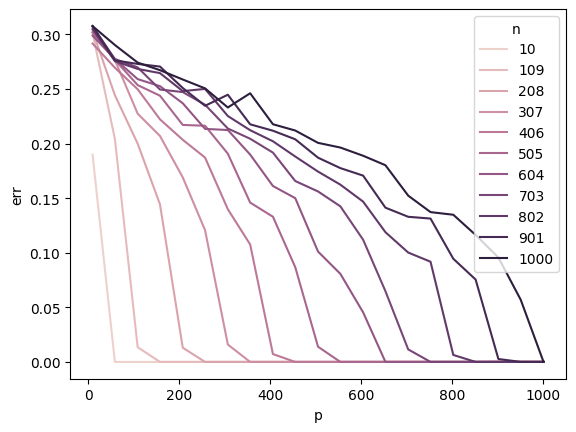

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import pandas as pd
import seaborn as sb
n_n = 11
n_p = 21
n_max = 1000
p_max = 1000

pairs = product(np.linspace(10,n_max,n_n).astype(int), np.linspace(10,p_max, n_p).astype(int))

errs_mat = np.zeros((n_n*n_p, 3))
k = 0
for n, p in tqdm(pairs):
    data = np.random.rand(n, p)
    x, y = data[:, :-1], data[:, [-1]]
    y_hat = x @ np.linalg.pinv(x.T@x)@(x.T@y)
    errs_mat[k] = [n, p, np.mean((y-y_hat)**2)**0.5]
    k+=1


errs = pd.DataFrame(errs_mat, columns=['n', 'p', 'err'])
errs = errs.astype({'n': int, 'p': int})

plt.figure()
sb.lineplot(x='p', y='err', data=errs, hue='n', legend='full')

Not surprisingly, for $n \sim p$, we can perfectly reconstruct the random target. This is due to the fact that building a singular matrix by chance is very difficult in high dimensions.